# Importing necessary Libraries

In [1]:
import os
import glob
import shutil
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms,datasets,models
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

import numpy as np 
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Writing Scripts to copy data from internal directory to working directory

In [3]:
src1=r"/kaggle/input/hotdog-silicon-valley/data/train"
src2=r"/kaggle/input/hotdog-silicon-valley/data/test"
src3=r"/kaggle/input/hotdog-silicon-valley/data/val"
dest1=r"/kaggle/working/train"
dest2=r"/kaggle/working/test"
dest3=r"/kaggle/working/validation"
shutil.copytree(src1,dest1)
shutil.copytree(src2,dest2)
shutil.copytree(src3,dest3)
        
hotdog_train="/kaggle/working/train/hotdog"
others_train="/kaggle/working/train/others"

hotdog_test="/kaggle/working/test/hotdog"
others_test="/kaggle/working/test/others"

hotdog_valid="/kaggle/working/validation/hotdog"
others_valid="/kaggle/working/validation/others"


In [4]:
print(len(os.listdir(hotdog_test)))
print(len(os.listdir(others_train)))

100
1550


# Removing Corrupt Images

In [5]:
from PIL import Image

# List of directories to check for corrupted images
directories = [
    "/kaggle/working/train/hotdog",
    "/kaggle/working/train/others",
    "/kaggle/working/test/hotdog",
    "/kaggle/working/test/others",
    "/kaggle/working/validation/hotdog",
    "/kaggle/working/validation/others"
]

def remove_corrupted_images(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            # Try to open the image
            with Image.open(file_path) as img:
                img.verify()  # Verify that it is, in fact, an image
        except (IOError, SyntaxError) as e:
            print(f"Removing corrupted image: {file_path}")
            os.remove(file_path)

for directory in directories:
    remove_corrupted_images(directory)


Removing corrupted image: /kaggle/working/train/hotdog/hotdogtrain1499.jpg
Removing corrupted image: /kaggle/working/train/hotdog/hotdogtrain346.jpg


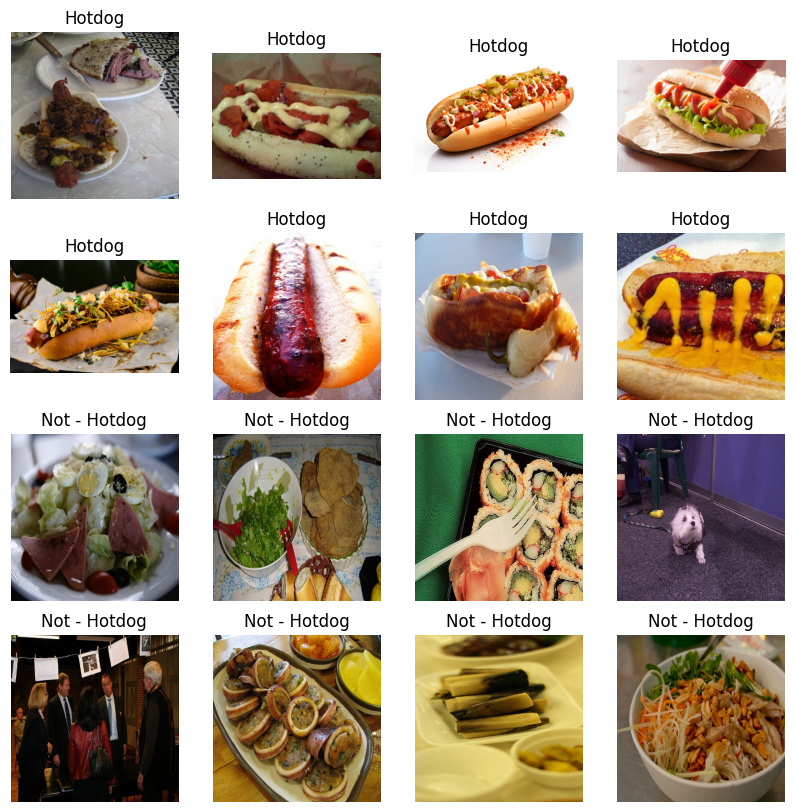

In [6]:
samples_hotdog = [os.path.join(hotdog_train,np.random.choice(os.listdir(hotdog_train),1)[0]) for _ in range(8)]
samples_others = [os.path.join(others_train,np.random.choice(os.listdir(others_train),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_hotdog[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
    ax[i].set_title('Hotdog')
  else:
    pic = plt.imread(samples_others[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
    ax[i].set_title('Not - Hotdog')
plt.show()

In [7]:
traindir = "/kaggle/working/train"
testdir = "/kaggle/working/test"
validdir="/kaggle/working/validation"

#transformations
img_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)])


#datasets
train_data = datasets.ImageFolder(traindir,transform=img_transforms)
test_data = datasets.ImageFolder(testdir,transform=img_transforms)
valid_data= datasets.ImageFolder(validdir,transform=img_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)
validloader= torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)


# Transfer Learning 

In [8]:
model = models.resnet18(pretrained=True)

#freeze all params
for params in model.parameters():
  params.requires_grad_ = False

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


In [9]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    
    optimizer.zero_grad()
    loss = loss_fn(yhat,y)
    loss.backward()
    optimizer.step()
    
    #optimizer.cleargrads()

    return loss
  return train_step

In [10]:
#loss
loss_fn = BCEWithLogitsLoss() 
#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 
#train step
train_step = make_train_step(model, optimizer, loss_fn)

# Writing the training loop

In [11]:
!pip install tqdm
from tqdm import tqdm    # it allows to show a gui for progress bar 

losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 15

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in testloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(testloader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
# saving the model state as well as model as a .pt file
state_dict_path = "/kaggle/working/model_state_dict.pt"
torch.save(model.state_dict(), state_dict_path)
torch.save(model,"/kaggle/working/detection.pt")
    

100%|██████████| 194/194 [00:14<00:00, 13.41it/s]



Epoch : 1, train loss : 0.44201353192329407
Epoch : 1, val loss : 0.45440056920051575


100%|██████████| 194/194 [00:12<00:00, 15.20it/s]



Epoch : 2, train loss : 0.30902624130249023
Epoch : 2, val loss : 0.4679470658302307


100%|██████████| 194/194 [00:13<00:00, 14.69it/s]



Epoch : 3, train loss : 0.265041321516037
Epoch : 3, val loss : 0.24912482500076294


100%|██████████| 194/194 [00:12<00:00, 15.11it/s]



Epoch : 4, train loss : 0.2618422508239746
Epoch : 4, val loss : 0.6393136978149414


100%|██████████| 194/194 [00:12<00:00, 14.98it/s]



Epoch : 5, train loss : 0.2393932044506073
Epoch : 5, val loss : 0.04800685867667198


100%|██████████| 194/194 [00:13<00:00, 14.83it/s]



Epoch : 6, train loss : 0.22999119758605957
Epoch : 6, val loss : 0.2176736295223236


100%|██████████| 194/194 [00:12<00:00, 15.22it/s]



Epoch : 7, train loss : 0.23183391988277435
Epoch : 7, val loss : 0.07495755702257156


100%|██████████| 194/194 [00:12<00:00, 15.00it/s]



Epoch : 8, train loss : 0.23256748914718628
Epoch : 8, val loss : 0.15071114897727966


100%|██████████| 194/194 [00:12<00:00, 15.18it/s]



Epoch : 9, train loss : 0.24438965320587158
Epoch : 9, val loss : 0.3459046185016632


100%|██████████| 194/194 [00:12<00:00, 15.01it/s]



Epoch : 10, train loss : 0.2247595191001892
Epoch : 10, val loss : 0.08920222520828247


100%|██████████| 194/194 [00:12<00:00, 15.30it/s]



Epoch : 11, train loss : 0.21832998096942902
Epoch : 11, val loss : 0.15412668883800507


100%|██████████| 194/194 [00:12<00:00, 15.15it/s]



Epoch : 12, train loss : 0.21215325593948364
Epoch : 12, val loss : 0.3992381691932678


100%|██████████| 194/194 [00:12<00:00, 15.26it/s]



Epoch : 13, train loss : 0.2038436383008957
Epoch : 13, val loss : 0.5414812564849854


100%|██████████| 194/194 [00:12<00:00, 15.46it/s]



Epoch : 14, train loss : 0.21138356626033783
Epoch : 14, val loss : 0.3668079376220703


100%|██████████| 194/194 [00:12<00:00, 15.19it/s]



Epoch : 15, train loss : 0.2027575969696045
Epoch : 15, val loss : 0.08395913243293762


Prediction : Hot Dog


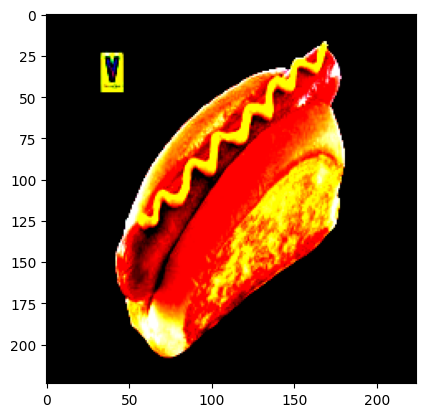

In [50]:
#making Predictions
def inference(valid_data):
  idx = torch.randint(1, len(valid_data), (1,))
  sample = torch.unsqueeze(valid_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : Hot Dog")
  else:
    print("Prediction : Not a Hot Dog")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(valid_data)

In [51]:
# train and test losses were tensors , so had to convert them to numpy arrays for plotting 
tensor_cpu=torch.tensor(epoch_train_losses).to('cpu')
train_losses=tensor_cpu.numpy()

tensor_cpuu=torch.tensor(epoch_test_losses).to('cpu')
test_losses=tensor_cpuu.numpy()

# PLOTTING THE LOSS CURVE

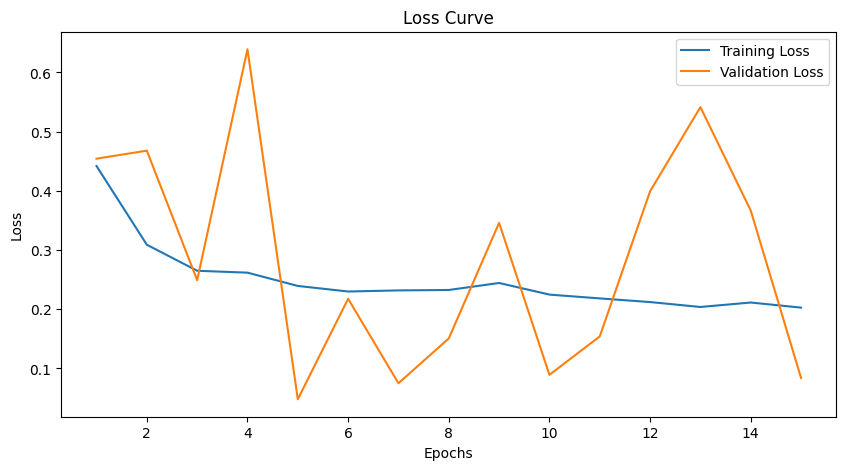

In [40]:
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()
